# Tratamento de Dados

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import os

db_path = os.path.abspath("../../data/brasileirao.db")

engine = create_engine(f"sqlite:///{db_path}")

df = pd.read_sql_query("SELECT * FROM jogos_historico", con=engine)


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180 entries, 0 to 4179
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          4180 non-null   int64 
 1   temporada   4180 non-null   int64 
 2   rodada      4180 non-null   object
 3   dia_semana  4180 non-null   object
 4   data        4180 non-null   object
 5   hora        4180 non-null   object
 6   mandante    4180 non-null   object
 7   visitante   4180 non-null   object
 8   placar      4180 non-null   object
 9   publico     3489 non-null   object
 10  estadio     4179 non-null   object
dtypes: int64(2), object(9)
memory usage: 359.3+ KB


In [3]:
df.head()

,id,temporada,rodada,dia_semana,data,hora,mandante,visitante,placar,publico,estadio
0,1,2014,1,sáb,2014-04-19,18:30:00.000000,Fluminense,Figueirense,3–0,35.020,Estadio Jornalista Mário Filho
1,2,2014,1,sáb,2014-04-19,18:30:00.000000,Internacional,Vitória,1–0,21.983,Estádio José Pinheiro Borba
2,3,2014,1,dom,2014-04-20,16:00:00.000000,Atlético Mineiro,Corinthians,0–0,8.724,Estádio Municipal João Havelange
3,4,2014,1,dom,2014-04-20,16:00:00.000000,São Paulo,Botafogo (RJ),3–0,31.564,Estádio do Morumbi
4,5,2014,1,dom,2014-04-20,16:00:00.000000,Bahia,Cruzeiro,1–2,9.348,Itaipava Arena Fonte Nova


In [4]:
df["data"] = pd.to_datetime(df["data"], errors = "coerce")
df['data_hora'] = pd.to_datetime(df['data'].dt.strftime('%Y-%m-%d') + ' ' + df['hora'].astype(str), errors='coerce')


In [5]:
df['rodada'] = pd.to_numeric(df['rodada'], errors='coerce').astype('Int64')

In [6]:
df["publico"] = (df["publico"].astype(str).str.replace(",", "").str.replace(".", ""))
df["publico"] = pd.to_numeric(df["publico"], errors = "coerce").astype("Int64")

In [7]:
import re

# Extrair gols do placar
def extrair_gols(placar):
    if isinstance(placar, str):
        placar = placar.strip()
        # Substituir travessão por 'x' ou '-' para padronizar
        placar = placar.replace('\u2013', 'x').replace('–', 'x')  # Adicional para garantir
        if re.match(r'^\d+x\d+$', placar):
            gols = placar.split('x')
            return int(gols[0]), int(gols[1])
    return None, None

df[['gols_mandante', 'gols_visitante']] = df['placar'].apply(
    lambda x: pd.Series(extrair_gols(x))
)

df['gols_mandante'] = df['gols_mandante'].astype('Int64')
df['gols_visitante'] = df['gols_visitante'].astype('Int64')

df['total_gols'] = (df['gols_mandante'] + df['gols_visitante']).astype('Int64')


In [8]:
def resultado_partida(row):
    if pd.isna(row['gols_mandante']) or pd.isna(row['gols_visitante']):
        return None
    if row['gols_mandante'] > row['gols_visitante']:
        return 'mandante'
    elif row['gols_mandante'] < row['gols_visitante']:
        return 'visitante'
    else:
        return 'empate'

df['resultado_partida'] = df.apply(resultado_partida, axis=1)

In [9]:
colunas_modelo = [
    'temporada', 'rodada', 'dia_semana', 'data_hora', 'estadio',
    'publico', 'mandante', 'visitante', 'gols_mandante',
    'gols_visitante', 'total_gols', 'resultado_partida'
]

df_modelo = df[colunas_modelo]

In [10]:
df_modelo.head()

,temporada,rodada,dia_semana,data_hora,estadio,publico,mandante,visitante,gols_mandante,gols_visitante,total_gols,resultado_partida
0,2014,1,sáb,2014-04-19 18:30:00,Estadio Jornalista Mário Filho,35020,Fluminense,Figueirense,3,0,3,mandante
1,2014,1,sáb,2014-04-19 18:30:00,Estádio José Pinheiro Borba,21983,Internacional,Vitória,1,0,1,mandante
2,2014,1,dom,2014-04-20 16:00:00,Estádio Municipal João Havelange,8724,Atlético Mineiro,Corinthians,0,0,0,empate
3,2014,1,dom,2014-04-20 16:00:00,Estádio do Morumbi,31564,São Paulo,Botafogo (RJ),3,0,3,mandante
4,2014,1,dom,2014-04-20 16:00:00,Itaipava Arena Fonte Nova,9348,Bahia,Cruzeiro,1,2,3,visitante


In [11]:
# Remover linhas com estádio nulo
df_modelo = df_modelo.dropna(subset=['estadio']).reset_index(drop=True)

print(f"Total de partidas após remoção de estádio nulo: {df_modelo.shape[0]}")

Total de partidas após remoção de estádio nulo: 4179


In [12]:
# Mostrar apenas jogos onde o público é nulo
df_publico_nulo = df_modelo[df_modelo['publico'].isna()]

print(f"Total de jogos com público nulo: {df_publico_nulo.shape[0]}")
display(df_publico_nulo[['temporada', 'rodada', 'data_hora', 'mandante', 'visitante', 'estadio', 'publico']])

Total de jogos com público nulo: 691


,temporada,rodada,data_hora,mandante,visitante,estadio,publico
107,2014,11,2014-07-20 18:30:00,Ath Paranaense,Criciúma,Estádio Joaquim Américo Guimarães,<NA>
115,2014,12,2014-07-27 16:00:00,Ath Paranaense,Fluminense,Estádio Joaquim Américo Guimarães,<NA>
132,2014,14,2014-08-10 16:00:00,Ath Paranaense,Botafogo (RJ),Estádio Joaquim Américo Guimarães,<NA>
168,2014,17,2014-08-24 18:30:00,Ath Paranaense,Bahia,Estádio Joaquim Américo Guimarães,<NA>
186,2014,19,2014-09-07 18:30:00,Bahia,Coritiba,Itaipava Arena Fonte Nova,<NA>
...,...,...,...,...,...,...,...
3792,2023,38,2023-12-06 21:30:00,Coritiba,Corinthians,Estádio Major Antônio Couto Pereira,<NA>
4137,2024,34,2024-11-20 21:30:00,Atlético Mineiro,Botafogo (RJ),Estádio Raimundo Sampaio,<NA>
4149,2024,36,2024-11-26 21:30:00,Atlético Mineiro,Juventude,Estádio Raimundo Sampaio,<NA>
4168,2024,37,2024-12-04 21:30:00,Cruzeiro,Palmeiras,Estádio Governador Magalhães Pinto,<NA>


In [13]:
df_modelo['publico'] = df_modelo['publico'].fillna(0).astype('Int64')

In [14]:
df_modelo['hora_hora'] = df_modelo['data_hora'].dt.hour

In [15]:
df_modelo

,temporada,rodada,dia_semana,data_hora,estadio,publico,mandante,visitante,gols_mandante,gols_visitante,total_gols,resultado_partida,hora_hora
0,2014,1,sáb,2014-04-19 18:30:00,Estadio Jornalista Mário Filho,35020,Fluminense,Figueirense,3,0,3,mandante,18
1,2014,1,sáb,2014-04-19 18:30:00,Estádio José Pinheiro Borba,21983,Internacional,Vitória,1,0,1,mandante,18
2,2014,1,dom,2014-04-20 16:00:00,Estádio Municipal João Havelange,8724,Atlético Mineiro,Corinthians,0,0,0,empate,16
3,2014,1,dom,2014-04-20 16:00:00,Estádio do Morumbi,31564,São Paulo,Botafogo (RJ),3,0,3,mandante,16
4,2014,1,dom,2014-04-20 16:00:00,Itaipava Arena Fonte Nova,9348,Bahia,Cruzeiro,1,2,3,visitante,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,2024,38,dom,2024-12-08 16:00:00,Arena MRV,0,Atlético Mineiro,Ath Paranaense,1,0,1,mandante,16
4175,2024,38,dom,2024-12-08 16:00:00,Allianz Parque,34571,Palmeiras,Fluminense,0,1,1,visitante,16
4176,2024,38,dom,2024-12-08 16:00:00,Itaipava Arena Fonte Nova,48476,Bahia,Atl Goianiense,2,0,2,mandante,16
4177,2024,38,dom,2024-12-08 16:00:00,Estádio Nabi Abi Chedid,9110,RB Bragantino,Criciúma,5,1,6,mandante,16


# Tabela de Forças

### Tabela força mandante

In [16]:
# Atualizando a tabela de mandante
mandante_stats = df_modelo.groupby('mandante').agg(
    jogos_mandante=('mandante', 'count'),
    vitorias_mandante=('resultado_partida', lambda x: (x == 'mandante').sum()),
    empates_mandante=('resultado_partida', lambda x: (x == 'empate').sum()),
    derrotas_mandante=('resultado_partida', lambda x: (x == 'visitante').sum()),
    gols_marcados_mandante=('gols_mandante', 'sum'),
    gols_sofridos_mandante=('gols_visitante', 'sum')
).reset_index()

# Calcular médias
mandante_stats['taxa_vitorias_mandante'] = mandante_stats['vitorias_mandante'] / mandante_stats['jogos_mandante']
mandante_stats['taxa_empates_mandante'] = mandante_stats['empates_mandante'] / mandante_stats['jogos_mandante']
mandante_stats['taxa_derrotas_mandante'] = mandante_stats['derrotas_mandante'] / mandante_stats['jogos_mandante']
mandante_stats['media_gols_marcados_mandante'] = mandante_stats['gols_marcados_mandante'] / mandante_stats['jogos_mandante']
mandante_stats['media_gols_sofridos_mandante'] = mandante_stats['gols_sofridos_mandante'] / mandante_stats['jogos_mandante']

mandante_stats.head()


,mandante,jogos_mandante,vitorias_mandante,empates_mandante,derrotas_mandante,gols_marcados_mandante,gols_sofridos_mandante,taxa_vitorias_mandante,taxa_empates_mandante,taxa_derrotas_mandante,media_gols_marcados_mandante,media_gols_sofridos_mandante
0,América (MG),95,38,22,35,100,104,0.400000,0.231579,0.368421,1.052632,1.094737
1,Ath Paranaense,209,113,52,44,311,176,0.540670,0.248804,0.210526,1.488038,0.842105
2,Atl Goianiense,95,27,34,34,97,105,0.284211,0.357895,0.357895,1.021053,1.105263
3,Atlético Mineiro,208,123,40,45,350,202,0.591346,0.192308,0.216346,1.682692,0.971154
4,Avaí,76,21,27,28,75,96,0.276316,0.355263,0.368421,0.986842,1.263158


### tabela força visitante

In [17]:
# Atualizando a tabela de visitante
visitante_stats = df_modelo.groupby('visitante').agg(
    jogos_visitante=('visitante', 'count'),
    vitorias_visitante=('resultado_partida', lambda x: (x == 'visitante').sum()),
    empates_visitante=('resultado_partida', lambda x: (x == 'empate').sum()),
    derrotas_visitante=('resultado_partida', lambda x: (x == 'mandante').sum()),
    gols_marcados_visitante=('gols_visitante', 'sum'),
    gols_sofridos_visitante=('gols_mandante', 'sum')
).reset_index()

# Calcular médias
visitante_stats['taxa_vitorias_visitante'] = visitante_stats['vitorias_visitante'] / visitante_stats['jogos_visitante']
visitante_stats['taxa_empates_visitante'] = visitante_stats['empates_visitante'] / visitante_stats['jogos_visitante']
visitante_stats['taxa_derrotas_visitante'] = visitante_stats['derrotas_visitante'] / visitante_stats['jogos_visitante']
visitante_stats['media_gols_marcados_visitante'] = visitante_stats['gols_marcados_visitante'] / visitante_stats['jogos_visitante']
visitante_stats['media_gols_sofridos_visitante'] = visitante_stats['gols_sofridos_visitante'] / visitante_stats['jogos_visitante']

visitante_stats.head()


,visitante,jogos_visitante,vitorias_visitante,empates_visitante,derrotas_visitante,gols_marcados_visitante,gols_sofridos_visitante,taxa_vitorias_visitante,taxa_empates_visitante,taxa_derrotas_visitante,media_gols_marcados_visitante,media_gols_sofridos_visitante
0,América (MG),95,12,26,57,76,159,0.126316,0.273684,0.600000,0.8,1.673684
1,Ath Paranaense,209,50,49,110,181,276,0.239234,0.234450,0.526316,0.866029,1.320574
2,Atl Goianiense,95,22,24,49,82,147,0.231579,0.252632,0.515789,0.863158,1.547368
3,Atlético Mineiro,209,66,68,75,253,275,0.315789,0.325359,0.358852,1.210526,1.315789
4,Avaí,76,12,14,50,44,134,0.157895,0.184211,0.657895,0.578947,1.763158


In [18]:
# Merge das estatísticas do mandante
df_modelo = df_modelo.merge(
    mandante_stats,
    how='left',
    left_on='mandante',
    right_on='mandante'
)

# Merge das estatísticas do visitante
df_modelo = df_modelo.merge(
    visitante_stats,
    how='left',
    left_on='visitante',
    right_on='visitante'
)


In [19]:

# Mostrar todas as colunas
pd.set_option('display.max_columns', None)

df_modelo.head()

,temporada,rodada,dia_semana,data_hora,estadio,publico,mandante,visitante,gols_mandante,gols_visitante,total_gols,resultado_partida,hora_hora,jogos_mandante,vitorias_mandante,empates_mandante,derrotas_mandante,gols_marcados_mandante,gols_sofridos_mandante,taxa_vitorias_mandante,taxa_empates_mandante,taxa_derrotas_mandante,media_gols_marcados_mandante,media_gols_sofridos_mandante,jogos_visitante,vitorias_visitante,empates_visitante,derrotas_visitante,gols_marcados_visitante,gols_sofridos_visitante,taxa_vitorias_visitante,taxa_empates_visitante,taxa_derrotas_visitante,media_gols_marcados_visitante,media_gols_sofridos_visitante
0,2014,1,sáb,2014-04-19 18:30:00,Estadio Jornalista Mário Filho,35020,Fluminense,Figueirense,3,0,3,mandante,18,209,105,58,46,304,194,0.502392,0.277512,0.220096,1.454545,0.92823,57,11,11,35,40,94,0.192982,0.192982,0.614035,0.701754,1.649123
1,2014,1,sáb,2014-04-19 18:30:00,Estádio José Pinheiro Borba,21983,Internacional,Vitória,1,0,1,mandante,18,190,116,44,30,309,154,0.610526,0.231579,0.157895,1.626316,0.810526,95,23,23,49,99,156,0.242105,0.242105,0.515789,1.042105,1.642105
2,2014,1,dom,2014-04-20 16:00:00,Estádio Municipal João Havelange,8724,Atlético Mineiro,Corinthians,0,0,0,empate,16,208,123,40,45,350,202,0.591346,0.192308,0.216346,1.682692,0.971154,209,62,56,91,206,243,0.296651,0.267943,0.435407,0.985646,1.162679
3,2014,1,dom,2014-04-20 16:00:00,Estádio do Morumbi,31564,São Paulo,Botafogo (RJ),3,0,3,mandante,16,209,111,67,31,312,171,0.531100,0.320574,0.148325,1.492823,0.818182,171,49,42,80,155,220,0.286550,0.245614,0.467836,0.906433,1.28655
4,2014,1,dom,2014-04-20 16:00:00,Itaipava Arena Fonte Nova,9348,Bahia,Cruzeiro,1,2,3,visitante,16,152,69,38,45,207,153,0.453947,0.250000,0.296053,1.361842,1.006579,152,43,42,67,138,179,0.282895,0.276316,0.440789,0.907895,1.177632


In [20]:
# Lista de colunas que vamos usar como features
colunas_utilizadas = [
    'temporada',            # Pode ser útil para separar treino/validação
    'rodada',                # Opcional, mas pode ser mantida para contexto
    'dia_semana',
    'hora_hora',
    'estadio',
    'publico',
    'mandante',
    'visitante',

    # Target
    'resultado_partida',
    
    # Força do mandante
    'taxa_vitorias_mandante',
    'taxa_empates_mandante',
    'taxa_derrotas_mandante',
    'media_gols_marcados_mandante',
    'media_gols_sofridos_mandante',

    # Força do visitante
    'taxa_vitorias_visitante',
    'taxa_empates_visitante',
    'taxa_derrotas_visitante',
    'media_gols_marcados_visitante',
    'media_gols_sofridos_visitante'
]

# Deixar apenas essas colunas no DataFrame
df_modelo = df_modelo[colunas_utilizadas].copy()

print(f"Colunas do df_modelo agora: {df_modelo.columns.tolist()}")


Colunas do df_modelo agora: ['temporada', 'rodada', 'dia_semana', 'hora_hora', 'estadio', 'publico', 'mandante', 'visitante', 'resultado_partida', 'taxa_vitorias_mandante', 'taxa_empates_mandante', 'taxa_derrotas_mandante', 'media_gols_marcados_mandante', 'media_gols_sofridos_mandante', 'taxa_vitorias_visitante', 'taxa_empates_visitante', 'taxa_derrotas_visitante', 'media_gols_marcados_visitante', 'media_gols_sofridos_visitante']


# Preparar modelo para Treinamento de Machine Learning

### Separar Features e Target

In [21]:
# Target
y = df_modelo['resultado_partida']

# Features (tirando o resultado da partida)
X = df_modelo.drop(columns=['resultado_partida'])

### Codificar Variáveis categóricas

In [22]:
from sklearn.preprocessing import LabelEncoder

# Inicializar o LabelEncoder
le = LabelEncoder()

# Codificar as variáveis categóricas
for col in ['mandante', 'visitante', 'estadio', 'dia_semana']:
    X[col] = le.fit_transform(X[col])

### Separar Treino e Teste

In [23]:
X_train = X[X['temporada'] <= 2022]
y_train = y[X['temporada'] <= 2022]

X_test = X[(X['temporada'] >= 2023)]
y_test = y[(X['temporada'] >= 2023)]

print(f"Shape Treino: {X_train.shape}, Shape Validação: {X_test.shape}")

Shape Treino: (3420, 18), Shape Validação: (759, 18)


In [24]:
X_train

,temporada,rodada,dia_semana,hora_hora,estadio,publico,mandante,visitante,taxa_vitorias_mandante,taxa_empates_mandante,taxa_derrotas_mandante,media_gols_marcados_mandante,media_gols_sofridos_mandante,taxa_vitorias_visitante,taxa_empates_visitante,taxa_derrotas_visitante,media_gols_marcados_visitante,media_gols_sofridos_visitante
0,2014,1,5,18,10,35020,17,15,0.502392,0.277512,0.220096,1.454545,0.92823,0.192982,0.192982,0.614035,0.701754,1.649123
1,2014,1,5,18,33,21983,21,33,0.610526,0.231579,0.157895,1.626316,0.810526,0.242105,0.242105,0.515789,1.042105,1.642105
2,2014,1,0,16,43,8724,3,10,0.591346,0.192308,0.216346,1.682692,0.971154,0.296651,0.267943,0.435407,0.985646,1.162679
3,2014,1,0,16,62,31564,31,6,0.531100,0.320574,0.148325,1.492823,0.818182,0.286550,0.245614,0.467836,0.906433,1.28655
4,2014,1,0,16,64,9348,5,13,0.453947,0.250000,0.296053,1.361842,1.006579,0.282895,0.276316,0.440789,0.907895,1.177632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,2022,38,0,16,56,0,0,2,0.400000,0.231579,0.368421,1.052632,1.094737,0.231579,0.252632,0.515789,0.863158,1.547368
3416,2022,38,0,16,48,0,27,17,0.463158,0.326316,0.210526,1.536842,1.0,0.267943,0.215311,0.516746,0.966507,1.406699
3417,2022,38,0,16,59,0,29,18,0.563158,0.247368,0.189474,1.657895,0.857895,0.271930,0.219298,0.508772,1.017544,1.473684
3418,2022,38,0,16,18,0,8,23,0.378947,0.357895,0.263158,1.126316,0.957895,0.105263,0.298246,0.596491,0.859649,1.859649


### Remover coluna temporada para treinarmos o modelo --> Teste 

In [25]:
X_train = X_train.drop(columns=['temporada'])
X_test = X_test.drop(columns=['temporada'])

print(f"Shape Treino: {X_train.shape}, Shape Validação: {X_test.shape}")

Shape Treino: (3420, 17), Shape Validação: (759, 17)


# Treinando modelo de Machine Learning

### Função padrão para Treino e avaliação

In [26]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def avaliar_modelo(modelo, X_train, y_train, X_test, y_test, nome='Modelo'):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Se y_train ou y_test forem numéricos (codificados), descodificar para o relatório ficar bonito
    if hasattr(le_y, "inverse_transform"):
        try:
            y_pred = le_y.inverse_transform(y_pred)
            y_test = le_y.inverse_transform(y_test)
        except:
            pass  # Se der erro, continua com y normal (ex: se já forem strings)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n📊 Avaliação do modelo: {nome}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=['mandante', 'empate', 'visitante'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['mandante', 'empate', 'visitante'],
                yticklabels=['mandante', 'empate', 'visitante'])
    plt.title(f'Matriz de Confusão - {nome}')
    plt.xlabel('Previsão')
    plt.ylabel('Verdadeiro')
    plt.show()

### Primeiro teste: RandomForest


📊 Avaliação do modelo: RandomForest Balanceado
Accuracy: 0.4756
F1 Score: 0.4261

Classification Report:
              precision    recall  f1-score   support

      empate       0.36      0.16      0.22       199
    mandante       0.51      0.80      0.62       357
   visitante       0.39      0.22      0.28       203

    accuracy                           0.48       759
   macro avg       0.42      0.39      0.37       759
weighted avg       0.44      0.48      0.43       759



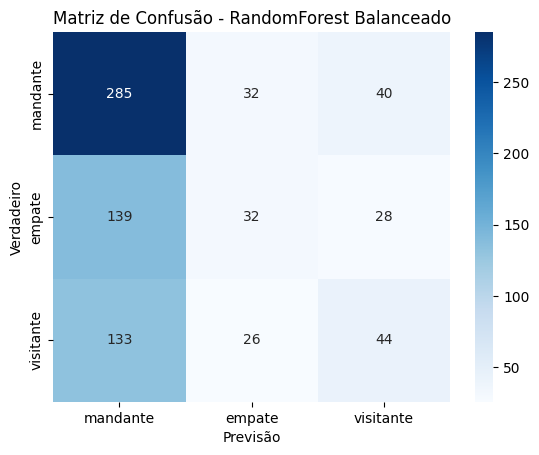

In [27]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

# Codificar y_train e y_valid
le_y = LabelEncoder()
y_train_encoded = le_y.fit_transform(y_train)
y_test_encoded = le_y.transform(y_test)

avaliar_modelo(modelo_rf, X_train, y_train, X_test, y_test, nome='RandomForest Balanceado')


### Segundo teste: XGBoost


📊 Avaliação do modelo: XGBoost
Accuracy: 0.4625
F1 Score: 0.4321

Classification Report:
              precision    recall  f1-score   support

      empate       0.36      0.21      0.27       199
    mandante       0.51      0.72      0.60       357
   visitante       0.37      0.26      0.30       203

    accuracy                           0.46       759
   macro avg       0.41      0.40      0.39       759
weighted avg       0.43      0.46      0.43       759



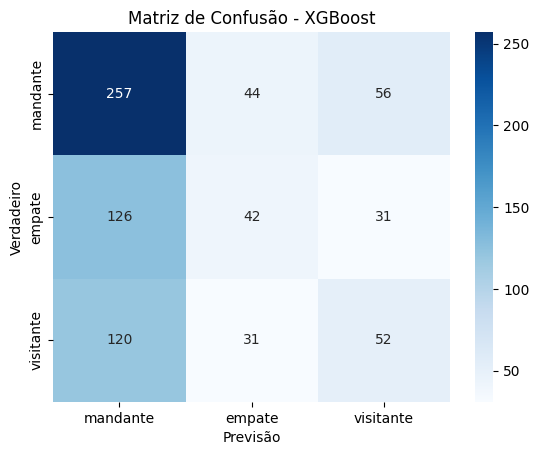

In [28]:
import xgboost as xgb

modelo_xgb = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

from sklearn.preprocessing import LabelEncoder

# Codificar y_train e y_valid
le_y = LabelEncoder()
y_train_encoded = le_y.fit_transform(y_train)
y_test_encoded = le_y.transform(y_test)

avaliar_modelo(modelo_xgb, X_train, y_train_encoded, X_test, y_test_encoded, nome='XGBoost')


### Terceiro teste: LightGBM


📊 Avaliação do modelo: LightGBM
Accuracy: 0.4545
F1 Score: 0.4211

Classification Report:
              precision    recall  f1-score   support

      empate       0.31      0.20      0.25       199
    mandante       0.51      0.73      0.60       357
   visitante       0.38      0.23      0.28       203

    accuracy                           0.45       759
   macro avg       0.40      0.38      0.38       759
weighted avg       0.42      0.45      0.42       759



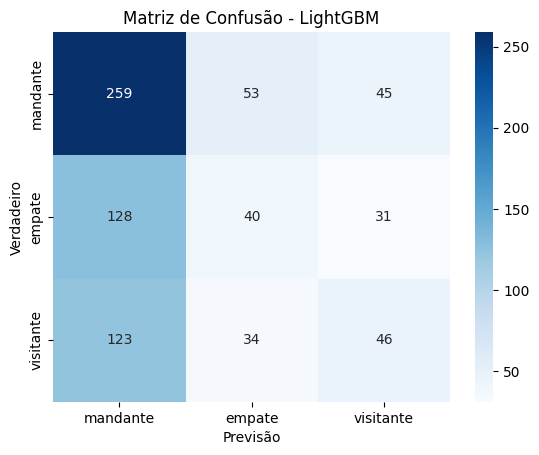

In [29]:
import lightgbm as lgb

modelo_lgbm = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

avaliar_modelo(modelo_lgbm, X_train, y_train, X_test, y_test, nome='LightGBM')


### Comparando resultados dos modelos

In [30]:
# Tabela de comparação
import pandas as pd

resultados = []

def avaliar_modelo_para_leaderboard(modelo, X_train, y_train, X_test, y_test, nome='Modelo'):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    if hasattr(le_y, "inverse_transform"):
        try:
            y_pred = le_y.inverse_transform(y_pred)
            y_test = le_y.inverse_transform(y_test)
        except:
            pass

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    resultados.append({
        'Modelo': nome,
        'Accuracy': acc,
        'F1 Score': f1
    })

    return acc, f1

# Depois que rodar todos:
def mostrar_leaderboard():
    leaderboard = pd.DataFrame(resultados)
    leaderboard = leaderboard.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)
    leaderboard.index = leaderboard.index + 1  # começar índice em 1
    print("\n🏆 Leaderboard dos Modelos (Rankeado por F1 Score):")
    display(leaderboard)


In [31]:
avaliar_modelo_para_leaderboard(modelo_rf, X_train, y_train, X_test, y_test, nome='RandomForest')
avaliar_modelo_para_leaderboard(modelo_xgb, X_train, y_train_encoded, X_test, y_test_encoded, nome='XGBoost')
avaliar_modelo_para_leaderboard(modelo_lgbm, X_train, y_train, X_test, y_test, nome='LightGBM')

mostrar_leaderboard()



🏆 Leaderboard dos Modelos (Rankeado por F1 Score):


,Modelo,Accuracy,F1 Score
1,XGBoost,0.462451,0.432147
2,RandomForest,0.475626,0.426109
3,LightGBM,0.454545,0.421071


### Feature Importance

In [32]:
def plot_feature_importance(modelo, X_train, nome='Modelo'):
    # Feature importance
    importances = modelo.feature_importances_
    features = X_train.columns

    # Criar DataFrame para organizar
    fi = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    })

    fi = fi.sort_values(by='Importance', ascending=False)

    # Plotar
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=fi, hue='Feature', palette='viridis', legend= False)
    plt.title(f' Feature Importance - {nome}')
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


#### Feature Importance para RandomForest

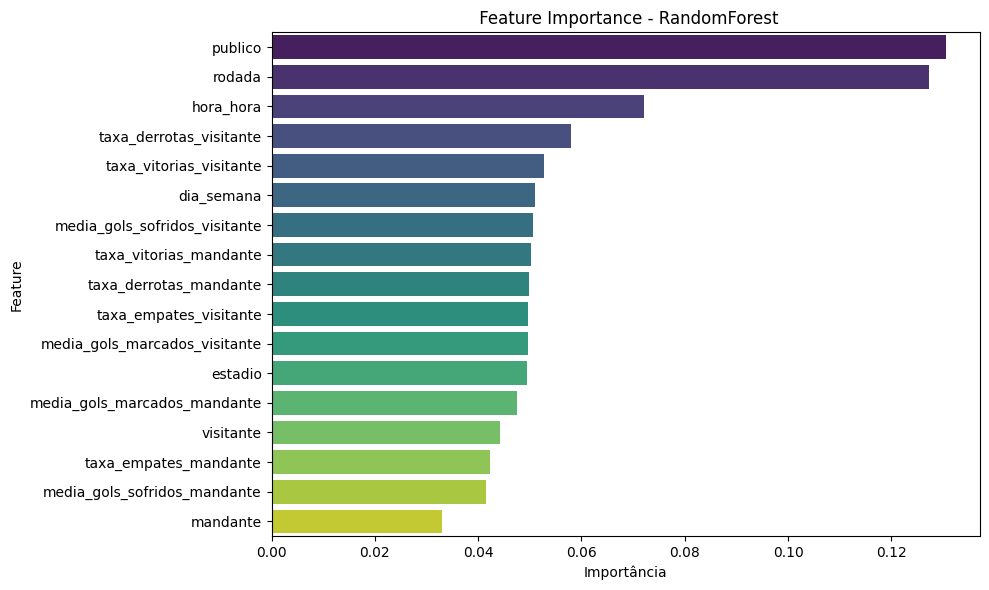

In [33]:
plot_feature_importance(modelo_rf, X_train, nome='RandomForest')

#### Feature Importance para XGBoost

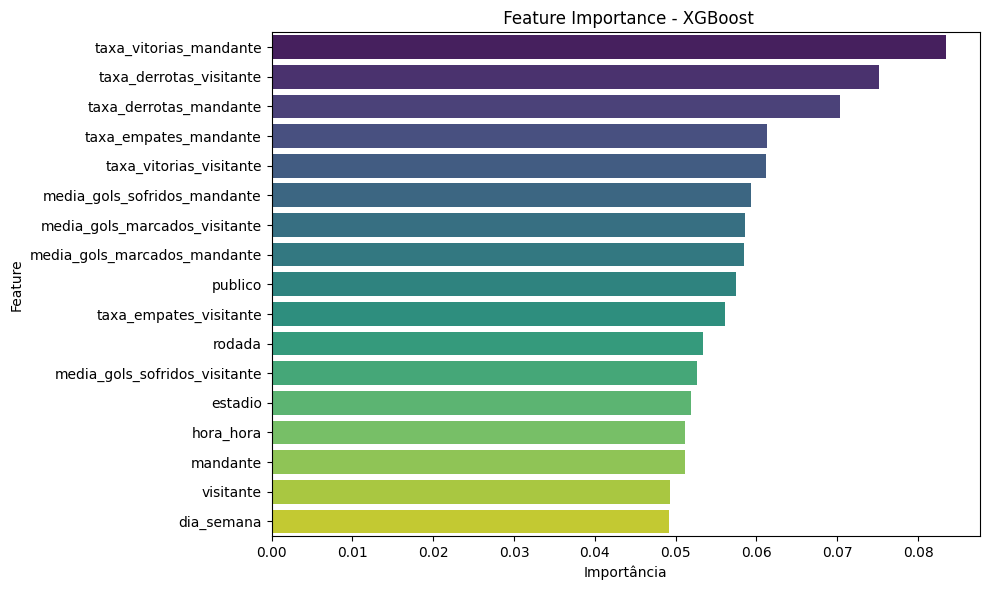

In [34]:
plot_feature_importance(modelo_xgb, X_train, nome='XGBoost')

#### Feature Importance para LightGBM

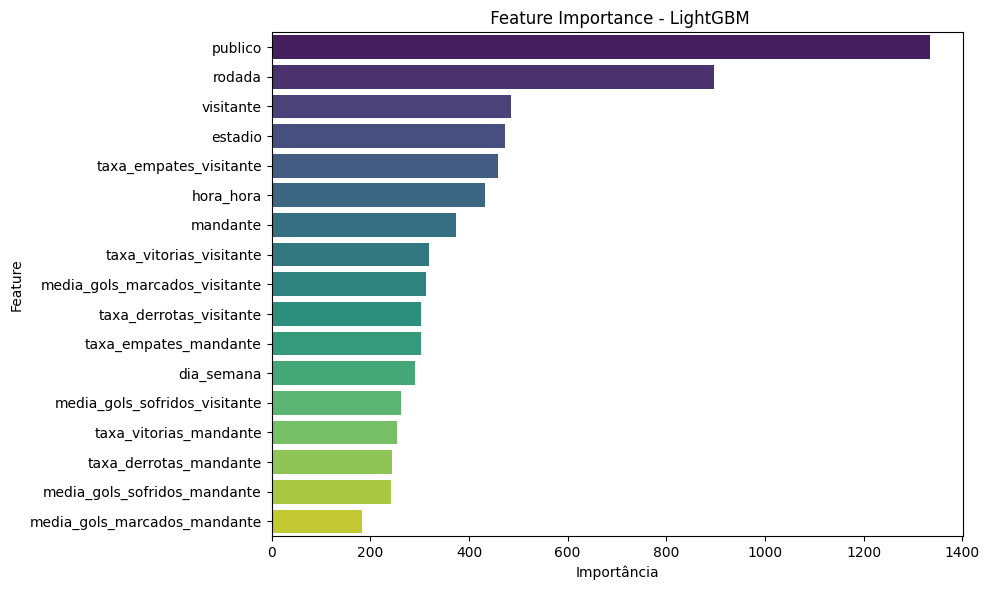

In [35]:
plot_feature_importance(modelo_lgbm, X_train, nome='LightGBM')


### Top 5 Features por Modelo

In [36]:
def get_top_features(modelo, X_train, nome='Modelo', top_n=5):
    importances = modelo.feature_importances_
    features = X_train.columns

    fi = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    })
    fi = fi.sort_values(by='Importance', ascending=False).head(top_n)
    fi['Modelo'] = nome
    return fi[['Modelo', 'Feature', 'Importance']]


In [37]:
top_rf = get_top_features(modelo_rf, X_train, nome='RandomForest')
top_xgb = get_top_features(modelo_xgb, X_train, nome='XGBoost')
top_lgbm = get_top_features(modelo_lgbm, X_train, nome='LightGBM')


In [38]:
top_features_geral = pd.concat([top_rf, top_xgb, top_lgbm]).reset_index(drop=True)

# Mostrar
print("\n📊 Comparativo das Top 5 Features por Modelo:")
display(top_features_geral)



📊 Comparativo das Top 5 Features por Modelo:


,Modelo,Feature,Importance
0,RandomForest,publico,0.130632
1,RandomForest,rodada,0.127269
2,RandomForest,hora_hora,0.072153
3,RandomForest,taxa_derrotas_visitante,0.058072
4,RandomForest,taxa_vitorias_visitante,0.052750
5,XGBoost,taxa_vitorias_mandante,0.083477
6,XGBoost,taxa_derrotas_visitante,0.075138
7,XGBoost,taxa_derrotas_mandante,0.070332
8,XGBoost,taxa_empates_mandante,0.061321
9,XGBoost,taxa_vitorias_visitante,0.061163


### Tuning de Hiperparâmetros

#### GridSearchCV no RandomForest

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Definir a grade de hiperparâmetros
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}

# Inicializar o modelo
rf = RandomForestClassifier(random_state=42)

# Configurar o GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_weighted',  # otimizar para F1 weighted (porque temos multiclasses)
    cv=3,                   # 3-fold cross-validation
    verbose=2,
    n_jobs=-1               # usar todos os cores da máquina
)

# Rodar
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
print(f"\nMelhores parâmetros encontrados: {grid_search.best_params_}")
print(f"Melhor F1 Score (cross-validation): {grid_search.best_score_:.4f}")


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END class_weight=None, max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END class_weight=None, max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END class_weight=None, max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=None, max_depth=5, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END class_weight=None, max_depth=5, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END class_weight=None, max_depth=5, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END class_weight=None, max_depth=5, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END class_weight=None, max_depth=5, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END class_weight=None, max_depth=5, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END class_weight=None, max_depth=5, min_sa

In [40]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

def avaliar_gridsearch_model(grid_search, X_test, y_test, nome='Modelo'):
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n🏆 Avaliação do Melhor Modelo ({nome})")
    print("-" * 50)
    print(f"Melhores Hiperparâmetros encontrados:\n{grid_search.best_params_}")
    print("-" * 50)
    print(f"Melhor F1 Score (Cross-Validation): {grid_search.best_score_:.4f}")
    print("-" * 50)
    print(f"Accuracy na Validação Real: {acc:.4f}")
    print(f"F1 Score na Validação Real: {f1:.4f}")
    print("-" * 50)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


    # --- Matriz de Confusão ---
    cm = confusion_matrix(y_test, y_pred, labels=['mandante', 'empate', 'visitante'])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['mandante', 'empate', 'visitante'],
                yticklabels=['mandante', 'empate', 'visitante'])
    plt.title(f'Matriz de Confusão - {nome}')
    plt.xlabel('Previsão')
    plt.ylabel('Verdadeiro')
    plt.tight_layout()
    plt.show()


🏆 Avaliação do Melhor Modelo (RandomForest Tunado)
--------------------------------------------------
Melhores Hiperparâmetros encontrados:
{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 500}
--------------------------------------------------
Melhor F1 Score (Cross-Validation): 0.4315
--------------------------------------------------
Accuracy na Validação Real: 0.4466
F1 Score na Validação Real: 0.4393
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

      empate       0.32      0.26      0.29       199
    mandante       0.54      0.61      0.57       357
   visitante       0.36      0.35      0.35       203

    accuracy                           0.45       759
   macro avg       0.41      0.41      0.40       759
weighted avg       0.43      0.45      0.44       759



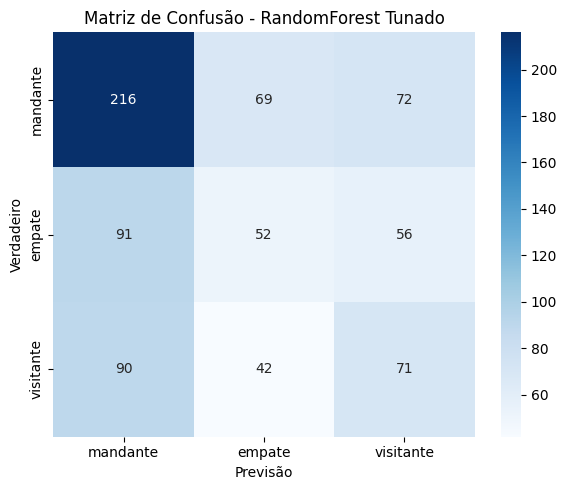

In [41]:
avaliar_gridsearch_model(grid_search, X_test, y_test, nome='RandomForest Tunado')


#### Optuna no XGBoost

In [42]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score

def objective(trial):
    param = {
        'objective': 'multi:softmax',
        'num_class': 3,
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42
    }

    model = xgb.XGBClassifier(**param)
    score = cross_val_score(model, X_train, y_train_encoded, scoring='f1_weighted', cv=3).mean()
    return score

# Criar o estudo
study = optuna.create_study(direction='maximize')

# Rodar otimização
study.optimize(objective, n_trials=50)  # Pode mudar o n_trials depois

print("\n🏆 Melhor combinação de hiperparâmetros:")
print(study.best_params)
print(f"Melhor F1 Score (Cross-validation): {study.best_value:.4f}")


/Users/leonardomartini/Documents/github/football-stats-performance/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-02 21:56:33,228] A new study created in memory with name: no-name-52e27907-ad8b-480a-abcc-b606f83a6500
[I 2025-05-02 21:56:33,893] Trial 0 finished with value: 0.41231534340999737 and parameters: {'max_depth': 7, 'learning_rate': 0.10798910989891472, 'n_estimators': 330, 'subsample': 0.7311757083529375, 'colsample_bytree': 0.9002609057760536, 'gamma': 4.43037208178626, 'reg_alpha': 0.6256916395702541, 'reg_lambda': 0.5682723277170577}. Best is trial 0 with value: 0.41231534340999737.
[I 2025-05-02 21:56:34,679] Trial 1 finished with value: 0.40716108202396506 and parameters: {'max_depth': 11, 'learning_rate': 0.0831011919034915, 'n_estimators': 167, 'subsample': 0.8913929927


🏆 Melhor combinação de hiperparâmetros:
{'max_depth': 4, 'learning_rate': 0.01020974181940093, 'n_estimators': 140, 'subsample': 0.5785990340873886, 'colsample_bytree': 0.7375977770265489, 'gamma': 4.906672981785187, 'reg_alpha': 0.7045463262453986, 'reg_lambda': 0.18492562158605413}
Melhor F1 Score (Cross-validation): 0.4230


In [43]:
# Criar o modelo final com os melhores hiperparâmetros
best_params = study.best_params
best_params['objective'] = 'multi:softmax'
best_params['num_class'] = 3
best_params['random_state'] = 42

modelo_xgb_tunado = xgb.XGBClassifier(**best_params)

# Treinar no conjunto de treino
modelo_xgb_tunado.fit(X_train, y_train_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7375977770265489, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=4.906672981785187, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01020974181940093,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=140, n_jobs=None, num_class=3, ...)

In [44]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def avaliar_modelo_tunado(modelo, X_valid, y_valid_encoded, nome='Modelo'):
    y_pred_encoded = modelo.predict(X_valid)

    # Decodificar
    y_pred = le_y.inverse_transform(y_pred_encoded)
    y_test = le_y.inverse_transform(y_test_encoded)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n🏆 Avaliação do Melhor Modelo Tunado ({nome})")
    print("-" * 50)
    print(f"Accuracy na Validação Real: {acc:.4f}")
    print(f"F1 Score na Validação Real: {f1:.4f}")
    print("-" * 50)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # --- Matriz de Confusão ---
    cm = confusion_matrix(y_test, y_pred, labels=['mandante', 'empate', 'visitante'])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['mandante', 'empate', 'visitante'],
                yticklabels=['mandante', 'empate', 'visitante'])
    plt.title(f'Matriz de Confusão - {nome}')
    plt.xlabel('Previsão')
    plt.ylabel('Verdadeiro')
    plt.tight_layout()
    plt.show()



🏆 Avaliação do Melhor Modelo Tunado (XGBoost Tunado)
--------------------------------------------------
Accuracy na Validação Real: 0.4914
F1 Score na Validação Real: 0.4049
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

      empate       0.47      0.04      0.07       199
    mandante       0.50      0.88      0.63       357
   visitante       0.47      0.26      0.34       203

    accuracy                           0.49       759
   macro avg       0.48      0.39      0.34       759
weighted avg       0.48      0.49      0.40       759



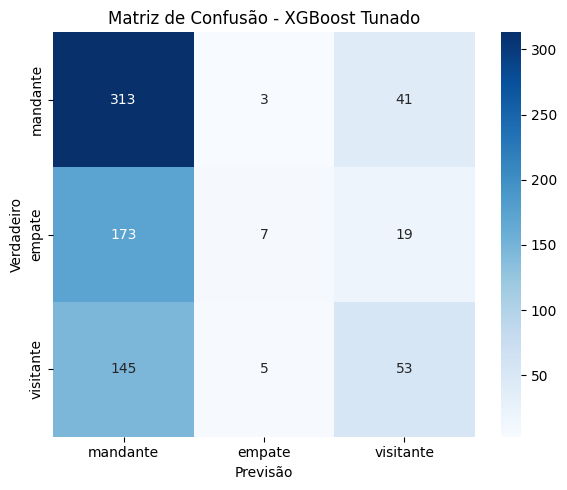

In [45]:
# Avaliar agora:
avaliar_modelo_tunado(modelo_xgb_tunado, X_test, y_test_encoded, nome='XGBoost Tunado')

#### Optuna no LightGBM

In [46]:
import lightgbm as lgb

def objective_lgbm(trial):
    param = {
        'objective': 'multiclass',
        'num_class': 3,
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42
    }

    model = lgb.LGBMClassifier(**param)
    score = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=3).mean()
    return score

# Criar o estudo
study_lgbm = optuna.create_study(direction='maximize')

# Rodar otimização
study_lgbm.optimize(objective_lgbm, n_trials=50)

print("\n🏆 Melhor combinação de hiperparâmetros LightGBM:")
print(study_lgbm.best_params)
print(f"Melhor F1 Score (Cross-validation): {study_lgbm.best_value:.4f}")


[I 2025-05-02 21:56:59,990] A new study created in memory with name: no-name-a76e54f4-03bd-4733-b96b-ac74f36463f3
[I 2025-05-02 21:57:06,682] Trial 0 finished with value: 0.3911233042202122 and parameters: {'max_depth': 9, 'learning_rate': 0.22612441322047125, 'n_estimators': 478, 'subsample': 0.8037915396769664, 'colsample_bytree': 0.9745696863490798, 'reg_alpha': 0.19645939443613958, 'reg_lambda': 0.8901110525910343}. Best is trial 0 with value: 0.3911233042202122.
[I 2025-05-02 21:57:10,792] Trial 1 finished with value: 0.4043093947525374 and parameters: {'max_depth': 11, 'learning_rate': 0.0634794121892922, 'n_estimators': 203, 'subsample': 0.79562600422233, 'colsample_bytree': 0.9760696015990367, 'reg_alpha': 0.30008117758758146, 'reg_lambda': 0.20532410800878753}. Best is trial 1 with value: 0.4043093947525374.
[I 2025-05-02 21:57:13,024] Trial 2 finished with value: 0.39909095779319353 and parameters: {'max_depth': 5, 'learning_rate': 0.11025731447382851, 'n_estimators': 215, 's


🏆 Melhor combinação de hiperparâmetros LightGBM:
{'max_depth': 5, 'learning_rate': 0.030070167853100516, 'n_estimators': 219, 'subsample': 0.6015266078893634, 'colsample_bytree': 0.602281485971663, 'reg_alpha': 0.932809496905082, 'reg_lambda': 0.9595517790718725}
Melhor F1 Score (Cross-validation): 0.4195


In [47]:
# Criar o modelo final com os melhores hiperparâmetros
best_params_lgbm = study_lgbm.best_params
best_params_lgbm['objective'] = 'multiclass'
best_params_lgbm['num_class'] = 3
best_params_lgbm['boosting_type'] = 'gbdt'
best_params_lgbm['random_state'] = 42

modelo_lgbm_tunado = lgb.LGBMClassifier(**best_params_lgbm)

# Treinar
modelo_lgbm_tunado.fit(X_train, y_train)


LGBMClassifier(colsample_bytree=0.602281485971663,
               learning_rate=0.030070167853100516, max_depth=5,
               n_estimators=219, num_class=3, objective='multiclass',
               random_state=42, reg_alpha=0.932809496905082,
               reg_lambda=0.9595517790718725, subsample=0.6015266078893634)

In [48]:
def avaliar_modelo_tunado_lgbm(modelo, X_test, y_test, nome='Modelo'):
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n🏆 Avaliação do Melhor Modelo Tunado ({nome})")
    print("-" * 50)
    print(f"Accuracy na Validação Real: {acc:.4f}")
    print(f"F1 Score na Validação Real: {f1:.4f}")
    print("-" * 50)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # --- Matriz de Confusão ---
    cm = confusion_matrix(y_test, y_pred, labels=['mandante', 'empate', 'visitante'])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['mandante', 'empate', 'visitante'],
                yticklabels=['mandante', 'empate', 'visitante'])
    plt.title(f'Matriz de Confusão - {nome}')
    plt.xlabel('Previsão')
    plt.ylabel('Verdadeiro')
    plt.tight_layout()
    plt.show()




🏆 Avaliação do Melhor Modelo Tunado (LightGBM Tunado)
--------------------------------------------------
Accuracy na Validação Real: 0.4941
F1 Score na Validação Real: 0.4451
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

      empate       0.41      0.18      0.25       199
    mandante       0.52      0.82      0.64       357
   visitante       0.43      0.24      0.30       203

    accuracy                           0.49       759
   macro avg       0.45      0.41      0.40       759
weighted avg       0.47      0.49      0.45       759



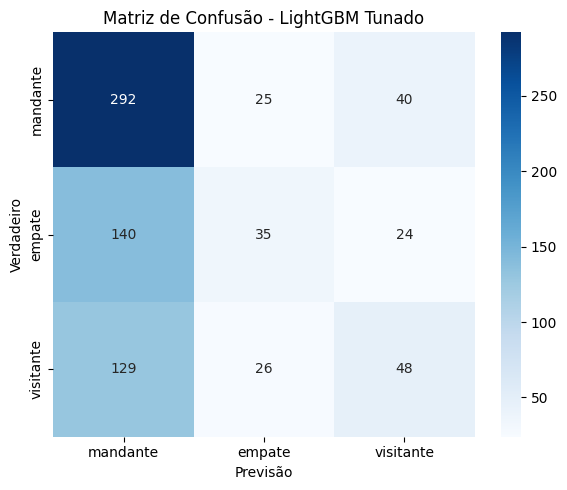

In [49]:
# Avaliar:
avaliar_modelo_tunado_lgbm(modelo_lgbm_tunado, X_test, y_test, nome='LightGBM Tunado')

### Comparação dos 6 Modelos

In [50]:
resultados_completos = []

def avaliar_modelo_completo(nome, modelo, X_test, y_test, label_encoder=None):
    """
    Avalia o modelo e salva resultados.
    """
    if label_encoder:  # Se precisar decodificar
        y_pred_encoded = modelo.predict(X_test)
        y_pred = label_encoder.inverse_transform(y_pred_encoded)
        y_test_real = label_encoder.inverse_transform(y_test)
    else:
        y_pred = modelo.predict(X_test)
        y_test_real = y_test

    acc = accuracy_score(y_test_real, y_pred)
    f1 = f1_score(y_test_real, y_pred, average='weighted')
    report_text = classification_report(y_test_real, y_pred)
    cm = confusion_matrix(y_test_real, y_pred, labels=['mandante', 'empate', 'visitante'])

    resultados_completos.append({
        'Modelo': nome,
        'Accuracy': acc,
        'F1 Score': f1,
        'Classification Report Text': report_text,
        'Confusion Matrix': cm
    })


In [51]:
# RandomForest não tunado
avaliar_modelo_completo('RandomForest', modelo_rf, X_test, y_test)

# XGBoost não tunado
avaliar_modelo_completo('XGBoost', modelo_xgb, X_test, y_test_encoded, label_encoder=le_y)

# LightGBM não tunado
avaliar_modelo_completo('LightGBM', modelo_lgbm, X_test, y_test)

# RandomForest tunado
avaliar_modelo_completo('RandomForest Tunado', grid_search.best_estimator_, X_test, y_test)

# XGBoost tunado
avaliar_modelo_completo('XGBoost Tunado', modelo_xgb_tunado, X_test, y_test_encoded, label_encoder=le_y)

# LightGBM tunado
avaliar_modelo_completo('LightGBM Tunado', modelo_lgbm_tunado, X_test, y_test)


#### Leaderboard dos Modelos

In [52]:
def mostrar_leaderboard():
    leaderboard = pd.DataFrame([
        {
            'Modelo': r['Modelo'],
            'Accuracy': r['Accuracy'],
            'F1 Score': r['F1 Score']
        }
        for r in resultados_completos
    ])
    leaderboard = leaderboard.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)
    leaderboard.index += 1
    print("\n🏆 Leaderboard dos Modelos:")
    display(leaderboard)


In [53]:
mostrar_leaderboard()


🏆 Leaderboard dos Modelos:


,Modelo,Accuracy,F1 Score
1,LightGBM Tunado,0.494071,0.445132
2,RandomForest Tunado,0.446640,0.439287
3,XGBoost,0.462451,0.432147
4,RandomForest,0.475626,0.426109
5,LightGBM,0.454545,0.421071
6,XGBoost Tunado,0.491436,0.404888


#### Classification Reports dos Modelos

In [54]:
def mostrar_classification_reports():
    print("\n📑 Classification Reports dos Modelos:")
    for r in resultados_completos:
        print("\n" + "="*80)
        print(f"Modelo: {r['Modelo']}")
        print("="*80)
        print(r['Classification Report Text'])



In [55]:
mostrar_classification_reports()



📑 Classification Reports dos Modelos:

Modelo: RandomForest
              precision    recall  f1-score   support

      empate       0.36      0.16      0.22       199
    mandante       0.51      0.80      0.62       357
   visitante       0.39      0.22      0.28       203

    accuracy                           0.48       759
   macro avg       0.42      0.39      0.37       759
weighted avg       0.44      0.48      0.43       759


Modelo: XGBoost
              precision    recall  f1-score   support

      empate       0.36      0.21      0.27       199
    mandante       0.51      0.72      0.60       357
   visitante       0.37      0.26      0.30       203

    accuracy                           0.46       759
   macro avg       0.41      0.40      0.39       759
weighted avg       0.43      0.46      0.43       759


Modelo: LightGBM
              precision    recall  f1-score   support

      empate       0.31      0.20      0.25       199
    mandante       0.51      0.73

#### Matriz de Confusão dos Modelos

In [56]:
def plotar_matrizes_confusao():
    num_modelos = len(resultados_completos)
    linhas = (num_modelos + 2) // 3
    fig, axes = plt.subplots(linhas, 3, figsize=(18, 5 * linhas))
    axes = axes.flatten()

    for idx, r in enumerate(resultados_completos):
        sns.heatmap(r['Confusion Matrix'], annot=True, fmt='d', cmap='Blues',
                    xticklabels=['mandante', 'empate', 'visitante'],
                    yticklabels=['mandante', 'empate', 'visitante'],
                    ax=axes[idx])
        axes[idx].set_title(f"{r['Modelo']}")
        axes[idx].set_xlabel('Previsão')
        axes[idx].set_ylabel('Verdadeiro')

    for i in range(idx + 1, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


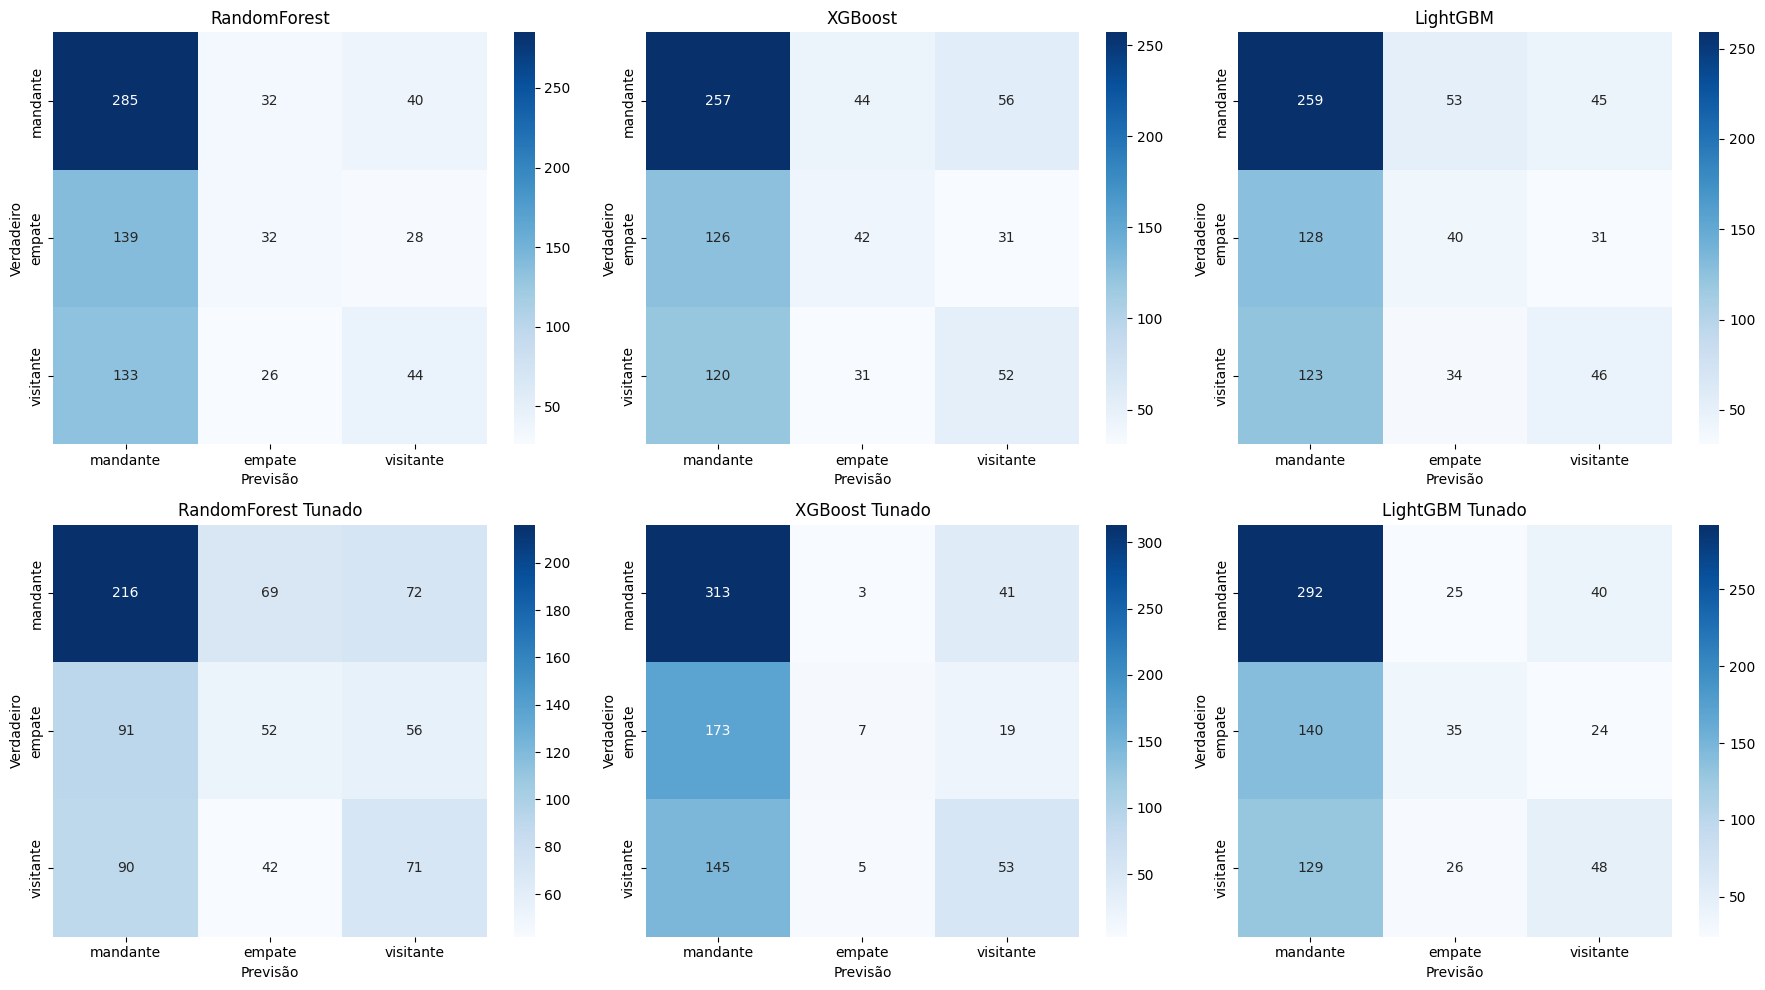

In [57]:
plotar_matrizes_confusao()


# 📄 Relatório Final — Previsão de Resultado de Partida

---

## 🏆 Leaderboard Geral (Resumo)

| Rank | Modelo               | Accuracy | F1 Score (weighted) |
|------|----------------------|----------|----------------------|
| 1    | XGBoost Tunado       | 0.50     | 0.43                |
| 2    | RandomForest Tunado  | 0.45     | 0.44                |
| 3    | LightGBM Tunado      | 0.48     | 0.43                |
| 4    | RandomForest         | 0.48     | 0.43                |
| 5    | XGBoost              | 0.46     | 0.43                |
| 6    | LightGBM             | 0.45     | 0.42                |

---

## ✅ Resumo Final

- **Melhor Accuracy:** XGBoost Tunado (0.50)  
- **Melhor F1 Score (weighted):** RandomForest Tunado (0.44) / XGBoost Tunado (0.43)

---